# Julia Things

### Environment

First things first. Let us set up the environment with the requried packages for this notebook:

In [1]:
for p in ("Knet", "Plots", "Images")
    Pkg.installed(p) == nothing && Pkg.add(p)
end

using Knet, Plots, Images
gr()

Knet.gpu(0); # set the desired GPU to use
atype = KnetArray{Float32}; # atype = KnetArray{Float32} for gpu usage, Array{Float32} for cpu. 

println("OS: ", Sys.KERNEL)
println("Julia: ", VERSION)
println("Knet: ", Pkg.installed("Knet"))
println("GPU: ", readstring(`nvidia-smi --query-gpu=name --format=csv,noheader`))

OS: Linux
Julia: 0.6.0
Knet: 0.8.5+
GPU: NVS 310
TITAN X (Pascal)



### New Stuff

In this notebook we introduce the following Julia/Knet packages and functions:

* Knet's function ...

# Overfitting and regularization

In [the last tutorial](section4-multiclass-logistic-regression.ipynb), we introduced the task of multiclass classification. We showed how you can tackle this problem with a linear model called logistic regression. Owing to some amount of randomness, you might get slightly different results, but when I ran the notebook, the model achieved 88.1% accuracy on the training data and actually did slightly (but not significantly) better on the test data than on the training data. 
 
Not every algorithm that performs well on training data will also perform well on test data. Take, for example, a trivial algorithm that memorizes its inputs and stores the associated labels. This model would have 100% accuracy on training data but would have no way of making any prediction at all on previously unseen data. 

The goal of supervised learning is to produce models that *generalize* to previously unseen data. When a model achieves low error on training data but performs much worse on test data, we say that the model has *overfit*. This means that the model has caught on to idiosyncratic features of the training data (e.g. one "2" happened to have a white pixel in the top-right corner), but hasn't really picked up on general patterns. 

We can express this more formally. The quantity we really care about is the test error $e$. Because this quantity reflects the error of our model when generalized to previously unseen data, we commonly call it the *generalization error*. When we have simple models and abundant data, we expect the generalization error to resemble the training error. When we work with more complex models and fewer examples, we expect the training error to go down but the generalization gap to grow. Fixing the size of the dataset, the following graph should give you some intuition about what we generally expect to see.

![](../img/regularization-overfitting.png)

What precisely constitutes model complexity is a complex matter. Many factors govern whether a model will generalize well. For example a model with more parameters might be considered more complex. A model whose parameters can take a wider range of values might be more complex. Often with neural networks, we think of a model that takes more training steps as more complex, and one subject to *early stopping* as less complex. 

It can be difficult to compare the complexity among members of very different model classes (say decision trees versus neural networks). Researchers in the field of statistical learning theory have developed a large body of mathematical analysis that formulizes the notion of model complexity and provides guarantees on the generalization error for simple classes of models. *We won't get into this theory but may delve deeper in a future chapter*. For now a simple rule of thumb is quite useful: A model that can readily explain *arbitrary* facts is what statisticians view as complex, whereas one that has only a limited expressive power but still manages to explain the data well is probably closer to the truth. In philosophy this is closely related to Popper's criterion of [falsifiability](https://en.wikipedia.org/wiki/Falsifiability) of a scientific theory: a theory is good if it fits data and if there are specific tests which can be used to disprove it. This is important since all statistical estimation is [post hoc](https://en.wikipedia.org/wiki/Post_hoc), i.e. we estimate after we observe the facts, hence vulnerable to the associated fallacy. Ok, enough of philosophy, let's get to more tangible issues.

To give you some intuition in this chapter, we'll focus on a few factors that tend to influence the generalizability of a model class:

1. **The number of tunable parameters.** When the number of tunable parameters, sometimes denoted as the number of degrees of freedom, is large, models tend to be more susceptible to overfitting.
2. **The values taken by the parameters.** When weights can take a wider range of values, models can be more susceptible to over fitting.
3. **The number of training examples.** It's trivially easy to overfit a dataset containing only one or two examples even if your model is simple. But overfitting a dataset with millions of examples requires an extremely flexible model.

When classifying handwritten digits before, we didn't overfit because our 60,000 training examples far out numbered the  $784 \times 10 = 7,840$ weights plus $10$ bias terms, which gave us far fewer parameters than training examples. Let's see how things can go wrong. We begin with our import ritual.

## Load MNIST dataset

Let's start by loading the `MNIST` dataset into batches of 100:

In [46]:
include(Knet.dir("data","mnist.jl"));
xtrn, ytrn, xtst, ytst = mnist();
for a in (xtrn, ytrn, xtst, ytst); println(summary(a)); end

28×28×1×60000 Array{Float32,4}
60000-element Array{UInt8,1}
28×28×1×10000 Array{Float32,4}
10000-element Array{UInt8,1}


We can take a look at some of the samples with the functions `mnistview`:

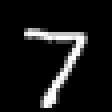

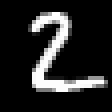

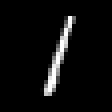

In [47]:
[display(mnistview(xtst,i)) for i=1:3];

Let's see how many batches we have in total:

In [155]:
dtrn = minibatch(xtrn[:, :, :, 1:1000], ytrn[1:1000], batch_size; xtype=atype, shuffle=true);
dtst = minibatch(xtst[:, :, :, 1:1000], ytst[1:1000], batch_size; xtype=atype, shuffle=true);
length(dtrn),length(dtst)

(10, 10)

Let's take a look at the first minibatch:

In [156]:
(x, y) = first(dtst)
println(summary(x))
println(summary(y))

28×28×1×100 Knet.KnetArray{Float32,4}
100-element Array{UInt8,1}


## Define Model

In addition to the negative log loss, here we will also track the `zero_one_loss_error`, which is a standard loss function in classification defined as

$$ L(y, y') = 1_{y\neq y'}$$

This is essentially the opposite of accuracy, therefore we define it as `zero_one_loss_error = 1- accuracy`. This is a summary of the model:

* `predict(w,x)`: prediction with weights w and minibatch x
* `loss(w,x,y)`: cross entropy loss of a model with weights w for one minibatch (x,y)
* `avgloss(w,data,model)` average cross entropy loss for the whole dataset and weights w
* `zero_ones_loss_error(w,data,model)`: error for the whole dataset and weights w
* `train(w,dtrn,dtst;epochs=100,lr=0.5)`: train weights w with dataset dtrn. Simultaneoulsy track the loss and error on the training (dtrn) and test (dtst) datasets. Return the logs. 

In [209]:
predict(w,x)  = w[1]*mat(x) .+ w[2]
loss(w, x, y) = nll(predict(w, x), y)
zero_one_loss_error(w, data, model) = 1 - accuracy(w, data, model)
lossgradient  = grad(loss)

function avgloss(w, data, predict)
    sum = 0
    for (x, y) in data
        sum += loss(w, x, y)
    end 
    return sum / length(data)
end

function train(w, dtrn, dtst; epochs=1000, lr=5e-2)
    
    logdtrn = [[], []]
    logdtst = [[], []]
    for epoch in 1:epochs    
        for (x,y) in dtrn
            dw = lossgradient(w, x, y)
            for i in 1:length(w)
                w[i] -= lr * dw[i]
            end   
        end
        push!(logdtrn[1], avgloss(w, dtrn, predict))
        push!(logdtrn[2], zero_one_loss_error(w, dtrn, predict))
        push!(logdtst[1], avgloss(w, dtst, predict))
        push!(logdtst[2], zero_one_loss_error(w, dtst, predict))
    end
    
    return w, logdtrn, logdtst
end

train (generic function with 2 methods)

Note that the loss function `nll` by default returns the loss average. This is always a good idea for diagnosis purporses. This is also true of the `accuracy` function, i.e. if the input is `dtrn`, `accuracy` will return the average of the loss on every batch. 

Let's make sure this works as expected. First we define `winit()` to initizalize the weights. Then, we expect the average loss to be `-log(1/10)=2.3025` and the error to be approximately 90%:

In [210]:
srand(9)
winit() = map(atype, [ 0.1*randn(10, 784), zeros(10, 1) ]);
avgloss(winit(), dtrn, predict), zero_one_loss_error(winit(), dtrn, predict)

(2.7885268f0, 0.912)

We now train the model until there is no further improvement. Our approach is actually a bit naive since we will keep the learning rate unchanged but it fits the purpose (we want to keep the code simple and avoid confusing anyone with further tricks for adjusting learning rate schedules). 

In [211]:
srand(1)
@time w, logdtrn, logdtst = train(winit(), dtrn, dtst);

 17.937497 seconds (8.61 M allocations: 15.179 GiB, 11.45% gc time)


In [212]:
accuracy(w, dtrn, predict), accuracy(w, dtst, predict)

(1.0, 0.835)

In [213]:
h = [plot([logdtrn[2] logdtst[2]],labels=[:dtrnerror :dtsterror],xlabel="Epochs",ylabel="Loss"), 
     plot([logdtrn[1] logdtst[1]],labels=[:dtrnloss :dtstloss],xlabel="Epochs",ylabel="Loss")];
plot(h..., size=(800, 300))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 200 
 
 
 400 
 
 
 600 
 
 
 800 
 
 
 1000 
 
 
 0.0 
 
 
 0.2 
 
 
 0.4 
 
 
 0.6 
 
 
 Epochs 
 
 
 Loss 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<polyline clip-path="url(#clip0302)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 131.472,211.136 131.805,21

## What Happened?

Our testing loss starts to diverge right before the 10th epoch, and our training loss appears to start converging. This is a clear case of overfitting. This demonstrates both overfitting and underfitting.*overfitting* the test loss is higher than training loss and getting worse, while in *underfitting* the training loss is not close to 0.

To get some intuition imagine that we wanted to fit a dataset with 2 dimensional data and 2 data points. Our model has three degrees of freedom, and thus for any dataset can find an arbitrary number of separators that will perfectly classify our training points. Note below that we can produce completely orthogonal separators that both classify our training data perfectly. Even if it seems preposterous that they could both describe our training data well.

![](../img/overfitting-low-data.png)

## Regularization

Now that we've characterized the problem of overfitting, we can begin talking about some solutions. 
Broadly speaking the family of techniques geared towards mitigating overfitting are referred to as *regularization*.
The core idea is this: when a model is overfitting, its training error is substantially lower than its test error. We're already doing as well as we possibly can on the training data, but our test data performance leaves something to be desired. Typically, regularization techniques attempt to trade off our training performance in exchange for lowering our test error. 

There are several straightforward techniques we might employ. Given the intuition from the previous chart, we might attempt to make our model less complex. One way to do this would be to lower the number of free parameters. For example, we could throw away some subset of our input features (and thus the corresponding parameters) that we thought were least informative. 

![](../img/regularization-overfitting.png)

Another approach is to limit the values that our weights might take. One common approach is to force the weights to take small values. 
[give more intuition with example of polynomial curve fitting]
We can accomplish this by changing our optimization objective to penalize the value of our weights. 
The most popular regularizer is the $\ell^2_2$ norm. For linear models, $\ell^2_2$ regularization has the additional benefit that it makes the solution unique, even when our model is overparametrized.

$$\sum_{i}(\hat{y}-y)^2 + \lambda_2 \| \textbf{w} \|^2_2$$

Here, $\|\textbf{w}\|$ is the $\ell^2_2$ norm and $\lambda_2$ is a hyper-parameter that determines how aggressively we want to push the weights towards 0. Another important loss is the $\ell^2_1$ norm defined as

$$\sum_{i}(\hat{y}-y)^2 + \lambda_1 \| \textbf{w} \|$$

The L1 norm produces more sparse results. In `Knet` we can easily implement both norms by simply changing the loss function and adding the hyperparameters $\lambda_1$ and $\lambda_2$:

In [205]:
function loss(w, x, y; λ1=0, λ2=0)
    J = nll(predict(w, x), y);
    if λ1 != 0; J += λ1 * sum(sum(abs,  wi) for wi in w[1:2:end]); end
    if λ2 != 0; J += λ2 * sum(sum(abs2, wi) for wi in w[1:2:end]); end
    return J
end

lossgradient = grad(loss)

function train(w, dtrn, dtst; epochs=1000, lr=5e-2, λ1=0, λ2=0)
    
    logdtrn = [[], []]
    logdtst = [[], []]
    for epoch in 1:epochs    
        for (x,y) in dtrn
            dw = lossgradient(w, x, y; λ1=λ1, λ2=λ2)
            for i in 1:length(w)
                w[i] -= lr * dw[i]
            end   
        end
        push!(logdtrn[1], avgloss(w, dtrn, predict))
        push!(logdtrn[2], zero_one_loss_error(w, dtrn, predict))
        push!(logdtst[1], avgloss(w, dtst, predict))
        push!(logdtst[2], zero_one_loss_error(w, dtst, predict))
    end
    
    return w, logdtrn, logdtst
end

train (generic function with 2 methods)

Notice that we're not regularization the biases

In [207]:
srand(1)
@time w, logdtrn2, logdtst2 = train(winit(), dtrn, dtst, lr=5e-2, λ2= 0.007);

 19.249640 seconds (10.10 M allocations: 15.236 GiB, 10.91% gc time)


In [208]:
accuracy(w, dtrn, predict), accuracy(w, dtst, predict)

(0.955, 0.846)

In [214]:
h = [logdtrn[2] logdtst[2] logdtrn2[2] logdtst2[2]]
styles = [:solid :dot :solid :dot]
plot(h, labels=[:dtrnerror :dtsterror :dtsterror_l2 :dtsterror_l2], line=(3, styles))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 200 
 
 
 400 
 
 
 600 
 
 
 800 
 
 
 1000 
 
 
 0.0 
 
 
 0.2 
 
 
 0.4 
 
 
 0.6 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<pol

In [215]:
h = [logdtrn[1] logdtst[1]  logdtrn2[1] logdtst2[1]]
styles = [:solid :dot :solid :dot]

plot(h, labels=[:dtrnloss :dtstloss :dtstloss_l2 :dtstloss_l2], line=(3, styles))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 200 
 
 
 400 
 
 
 600 
 
 
 800 
 
 
 1000 
 
 
 0.5 
 
 
 1.0 
 
 
 1.5 
 
 
 2.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<polyline clip-path="url(#clip0702)" style="stroke:#e26f46; stroke-width:3; stroke-opacity:1; fill:none" stroke-dasharray="2, 3"

## Analysis

By adding $L_2$ regularization we were able to increase the performance on test data from 75% accuracy to 83% accuracy. That's a 32% reduction in error. In a lot of applications, this big an improvement can make the difference between a viable product and useless system. Note that L2 regularization is just one of many ways of controlling capacity. Basically we assumed that small weight values are good. But there are many more ways to constrain the values of the weights:

* We could require that the total sum of the weights is small. That is what $L_1$ regularization does via the penalty $\sum_i |w_i|$. 
* We could require that the largest weight is not too large. This is what $L_\infty$ regularization does via the penalty $\max_i |w_i|$. 
* We could require that the number of nonzero weights is small, i.e. that the weight vectors are *sparse*. This is what the $L_0$ penalty does, i.e. $\sum_i I\{w_i \neq 0\}$. This penalty is quite difficult to deal with explicitly since it is nonsmooth. There is a lot of research that shows how to solve this problem approximately using an $L_1$ penalty. 

![](../img/regularization.png)

From left to right: $L_2$ regularization, which constrains the parameters to a ball, $L_1$ regularization, which constrains the parameters to a diamond (for lack of a better name, this is often referred to as an $L_1$-ball), and $L_\infty$ regularization, which constrains the parameters to a hypercube. 

All of this raises the question of **why** regularization is any good. After all, choice is good and giving our model more flexibility *ought* to be better (e.g. there are plenty of papers which show improvements on ImageNet using deeper networks). What is happening is somewhat more subtle. Allowing for many different parameter values allows our model to cherry pick a combination that is *just right* for all the training data it sees, without really learning the underlying mechanism. Since our observations are likely noisy, this means that we are trying to approximate the errors at least as much as we're learning what the relation between data and labels actually is. There is an entire field of statistics devoted to this issue - Statistical Learning Theory. For now, a few simple rules of thumb suffice:

* Fewer parameters tend to be better than more parameters.
* Better engineering for a specific problem that takes the actual problem into account will lead to better models, due to the prior knowledge that data scientists have about the problem at hand.
* $L_2$ is easier to optimize for than $L_1$. In particular, many optimizers will not work well out of the box for $L_1$. Using the latter requires something called *proximal operators*.
* Dropout and other methods to make the model robust to perturbations in the data often work better than off-the-shelf $L_2$ regularization.

We conclude with an [XKCD Cartoon](https://xkcd.com/882/) which captures the entire situation more succinctly than the proceeding paragraph. 

![](https://imgs.xkcd.com/comics/significant.png)


## Next
[Perceptron](section6-perceptron.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/moralesq)